In [1]:
# Import essential libraries for data analysis and visualization:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from ucimlrepo import fetch_ucirepo

In [2]:
# Load dataset to dataframe
df = pd.read_excel('Online Retail.xlsx')

# View the last five rows of the dataframe
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [3]:
# Dataframe summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Check for count of duplicated rows
df.duplicated().sum()

5268

In [5]:
# Create wrangle function to use for data cleaning
def wrangle(df):
    df = df.copy()

    # Ensure required columns exist
    required = ['CustomerID', 'Quantity', 'UnitPrice']
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Drop rows with missing CustomerID
    df = df.dropna(subset=['CustomerID'])

    # Convert CustomerID to int safely
    df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').dropna().astype(int)

    # Filter out invalid sales
    df = df[(df['Quantity'] > 0)]
    df = df[(df['UnitPrice'] > 0)]
    
    # Calculate SalesValue
    df['SalesValue'] = df['UnitPrice'] * df['Quantity']

    columns_to_check = [
        'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
        'UnitPrice', 'CustomerID', 'Country', 'SalesValue'
    ]
    
    # Drop exact duplicates across the listed columns
    df = df.drop_duplicates(subset=columns_to_check)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df


In [6]:
# USe wrangle function to clean dataframe df and save as onret
onret = wrangle(df)

# Onret dataframe summary
onret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   SalesValue   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 25.5+ MB


In [7]:
# Check count of duplicated rows in onret dataframe
onret.duplicated().sum()

0

In [8]:
# Reference date for Recency, Frequency and Monetary
ref_date = onret['InvoiceDate'].max() + dt.timedelta(days=1)

In [9]:
# Group dataframe by CustomerID and calculate RFM metrics
rfm = onret.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'SalesValue': 'sum'                                        # Monetary
}).reset_index()

# Rename rfm columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [10]:
# Assign RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine individual R, F, and M scores into a single RFM segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [11]:
# Create a function to classify customers
def segment_customer(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5:
        return 'Champion'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Loyal'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'Recent'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Others'

# Use segment_customer to classify customers
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [12]:
# Save rfm to csv file
rfm.to_csv("rfm_output.csv", index=False)


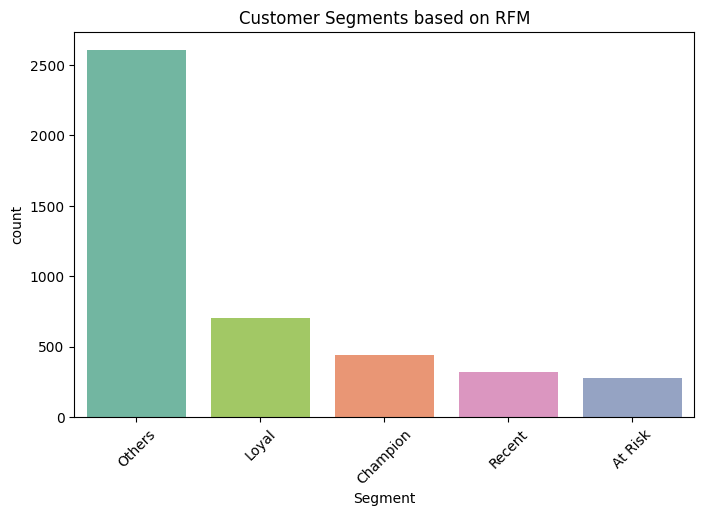

In [13]:
# Plot distribution of customers based on RFM
plt.figure(figsize=(8, 5))
sns.countplot(
    data=rfm,
    x='Segment',
    hue='Segment',  # <— Use the same variable for hue
    order=rfm['Segment'].value_counts().index,
    palette='Set2',
    legend=False  # <— Turn off duplicate legend
)
plt.title("Customer Segments based on RFM")
plt.xticks(rotation=45)
plt.show()


In [14]:
# Total revenue by country
result = (
    onret.groupby('Country')['SalesValue']
    .sum()
    .round(2)
    .sort_values(ascending=False)
    .reset_index()
)

# Rename result columns
result.columns = ['Country', 'TotalSalesValue']

# Top 10 countries by 'TotalSalesValue'
result.head(10)

,Country,TotalSalesValue
0,United Kingdom,7285024.64
1,Netherlands,285446.34
2,EIRE,265262.46
3,Germany,228678.40
4,France,208934.31
5,Australia,138453.81
6,Spain,61558.56
7,Switzerland,56443.95
8,Belgium,41196.34
9,Sweden,38367.83


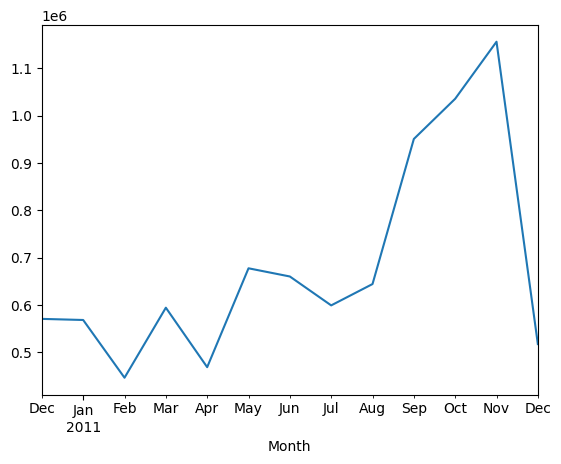

In [15]:
# Monthly sales
onret['Month'] = onret['InvoiceDate'].dt.to_period('M')
onret.groupby('Month')['SalesValue'].sum().plot(kind='line');


In [16]:
# Cohort grouping by first purchase month
cohort = onret.groupby('CustomerID')['Month'].min().reset_index()
cohort.columns = ['CustomerID', 'CohortMonth']
onret = onret.merge(cohort, on='CustomerID')

# Calculate CohortIndex
onret['CohortIndex'] = (
    (onret['Month'].dt.year - onret['CohortMonth'].dt.year) * 12 +
    (onret['Month'].dt.month - onret['CohortMonth'].dt.month)
)

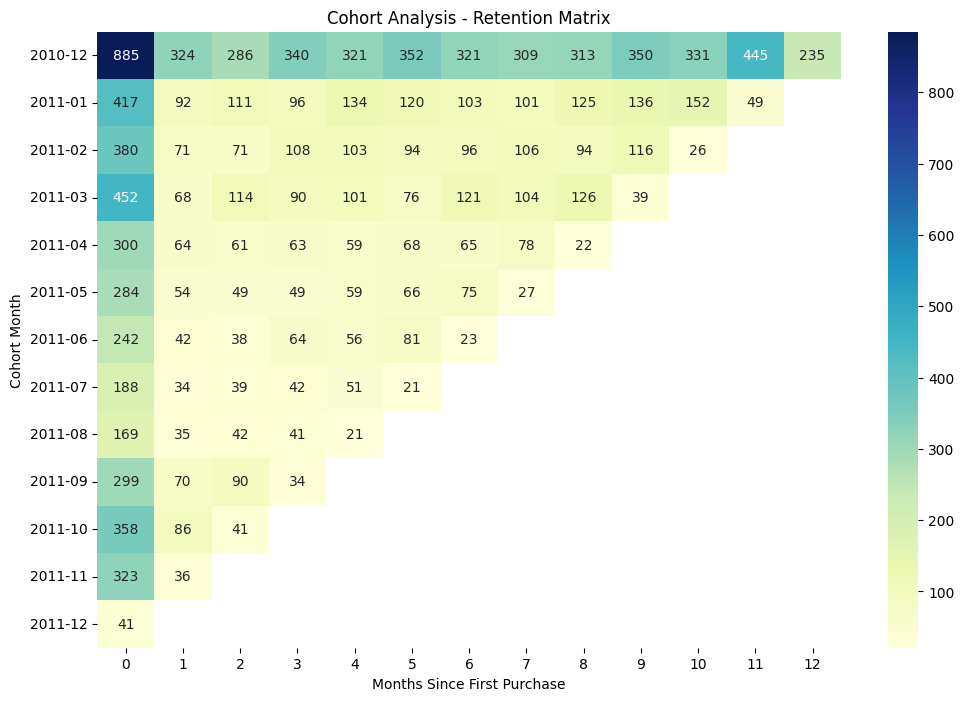

In [17]:
# Cohort Retention Matrix (Heatmap)
cohort_data = onret.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_counts, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Cohort Analysis - Retention Matrix')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show();

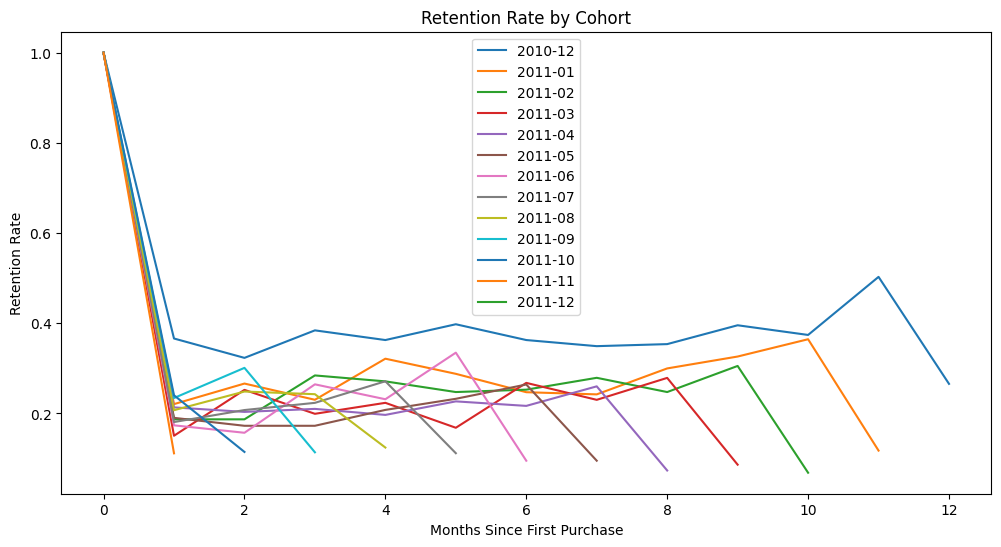

In [18]:
# Retention Rate Over Time
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

plt.figure(figsize=(12, 6))
for i in retention.index:
    plt.plot(retention.columns, retention.loc[i], label=str(i))
plt.title('Retention Rate by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.legend()
plt.show();

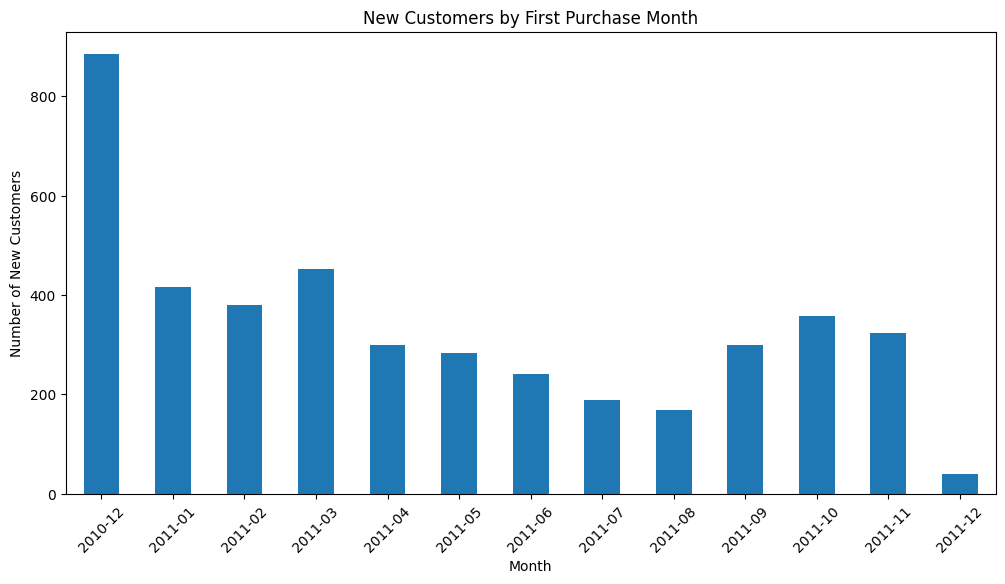

In [19]:
# New Customers by Month
new_customers = onret.drop_duplicates(subset='CustomerID')[['CustomerID', 'CohortMonth']]
monthly_new_customers = new_customers['CohortMonth'].value_counts().sort_index()

monthly_new_customers.plot(kind='bar', figsize=(12, 6))
plt.title('New Customers by First Purchase Month')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.show();

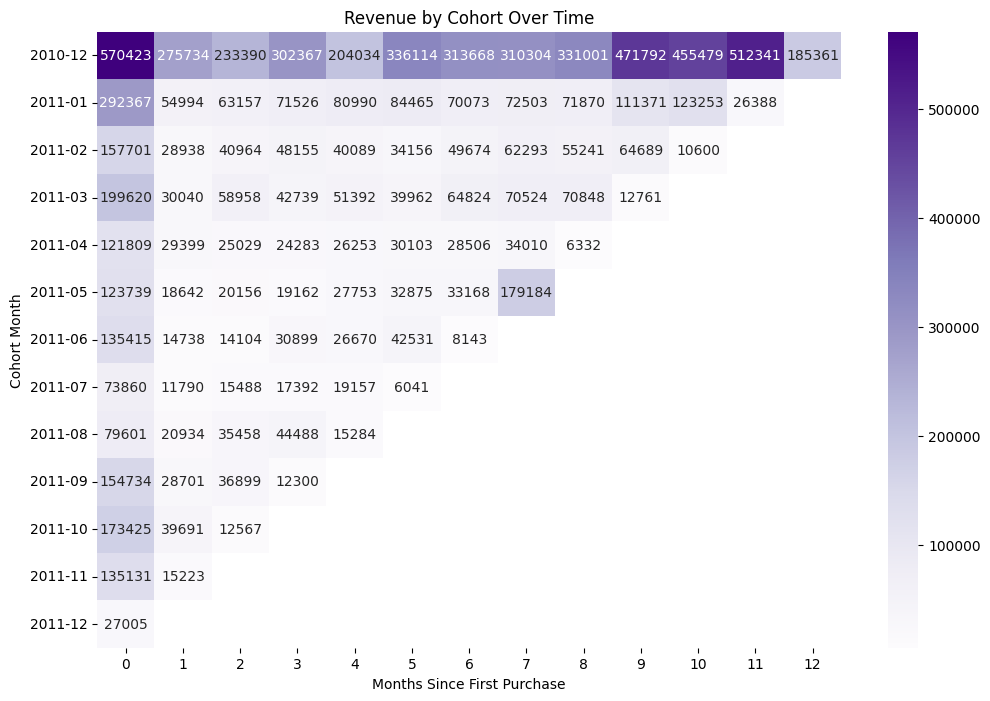

In [20]:
# Revenue by Cohort Over Time
revenue_data = onret.groupby(['CohortMonth', 'CohortIndex'])['SalesValue'].sum().reset_index()
revenue_pivot = revenue_data.pivot(index='CohortMonth', columns='CohortIndex', values='SalesValue')

plt.figure(figsize=(12, 8))
sns.heatmap(revenue_pivot, annot=True, fmt='.0f', cmap='Purples')
plt.title('Revenue by Cohort Over Time')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show();

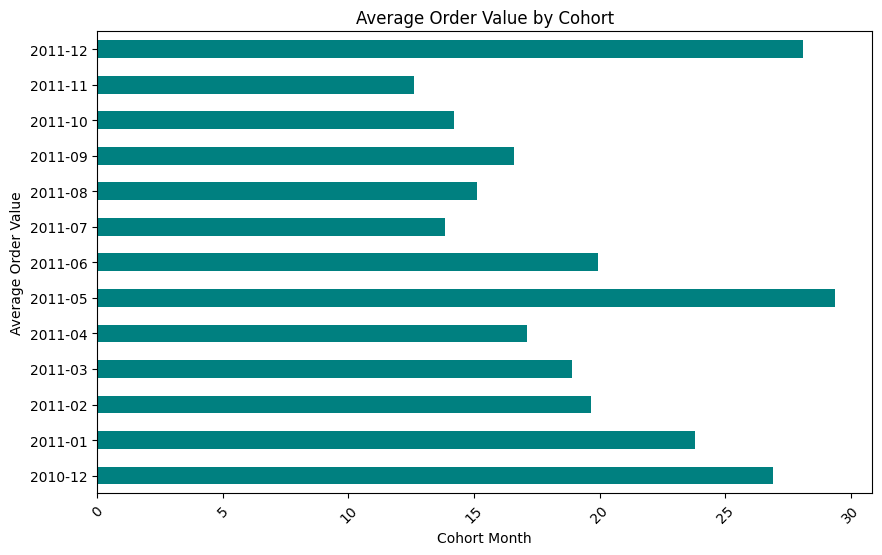

In [21]:
# Average Order Value (AOV) by Cohort
aov_data = onret.groupby(['CohortMonth'])['SalesValue'].mean()

aov_data.plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Average Order Value by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.show();

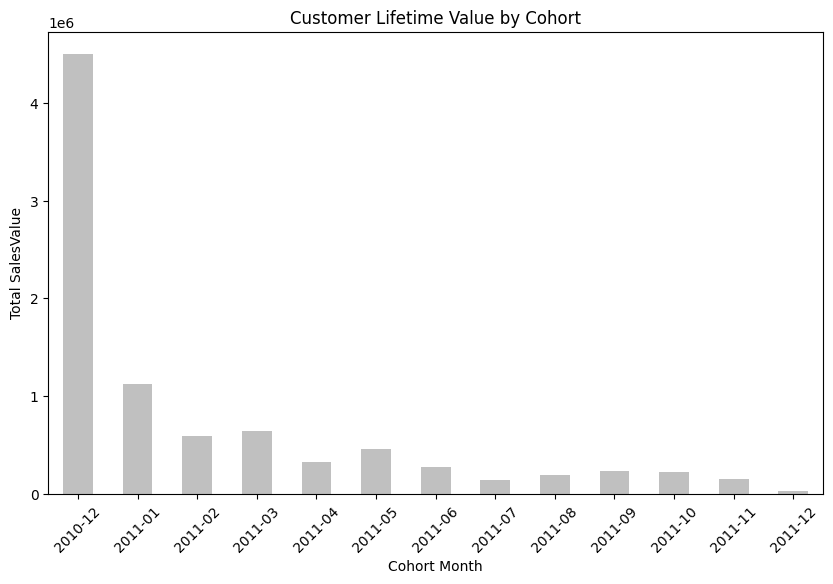

In [22]:
# Customer Lifetime Value (CLV) by Cohort
clv_data = onret.groupby('CohortMonth')['SalesValue'].sum()

clv_data.plot(kind='bar', figsize=(10, 6), color='silver')
plt.title('Customer Lifetime Value by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Total SalesValue')
plt.xticks(rotation=45)
plt.show();

In [23]:
# Returns are rows where Quantity is negative
returns_df = df[df['Quantity'] < 0]

# Optional: Check total number of returns
print("Number of returns:", returns_df.shape[0])


Number of returns: 10624


In [24]:
# Group by product and sum returned quantities
top_returned_products = (
    returns_df
    .groupby('Description')['Quantity']
    .sum()
    .sort_values()
    .reset_index()
)

# Top 10 most returned products
top_10 = top_returned_products.head(10)

top_10

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",-80995
1,MEDIUM CERAMIC TOP STORAGE JAR,-74494
2,printing smudges/thrown away,-19200
3,"Unsaleable, destroyed.",-15644
4,check,-13247
5,?,-9496
6,ROTATING SILVER ANGELS T-LIGHT HLDR,-9376
7,Printing smudges/thrown away,-9058
8,Damaged,-7540
9,throw away,-5368


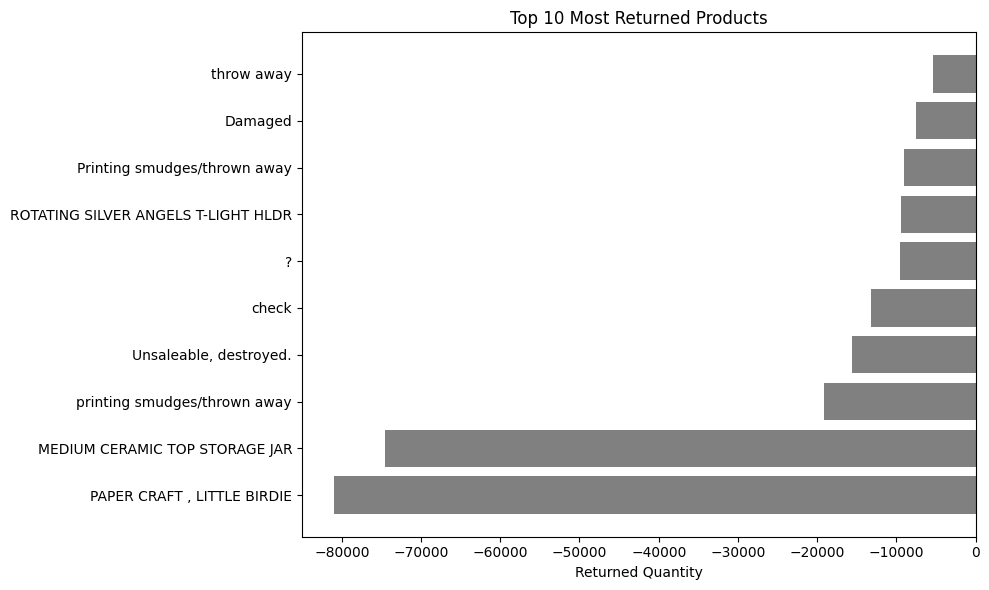

In [25]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['Description'], top_10['Quantity'], color='grey')
plt.xlabel('Returned Quantity')
plt.title('Top 10 Most Returned Products')
plt.tight_layout()
plt.show();

In [26]:
# Group by customer and sum quantity
top_returning_customers = (
    returns_df
    .groupby('CustomerID')['Quantity']
    .sum()
    .sort_values()
    .reset_index()
)

trc = top_returning_customers.head(10)

trc


,CustomerID,Quantity
0,16446.0,-80995
1,12346.0,-74215
2,15838.0,-9361
3,15749.0,-9014
4,16029.0,-8060
5,12931.0,-4627
6,14607.0,-3768
7,14911.0,-3335
8,17949.0,-2975
9,12901.0,-2160


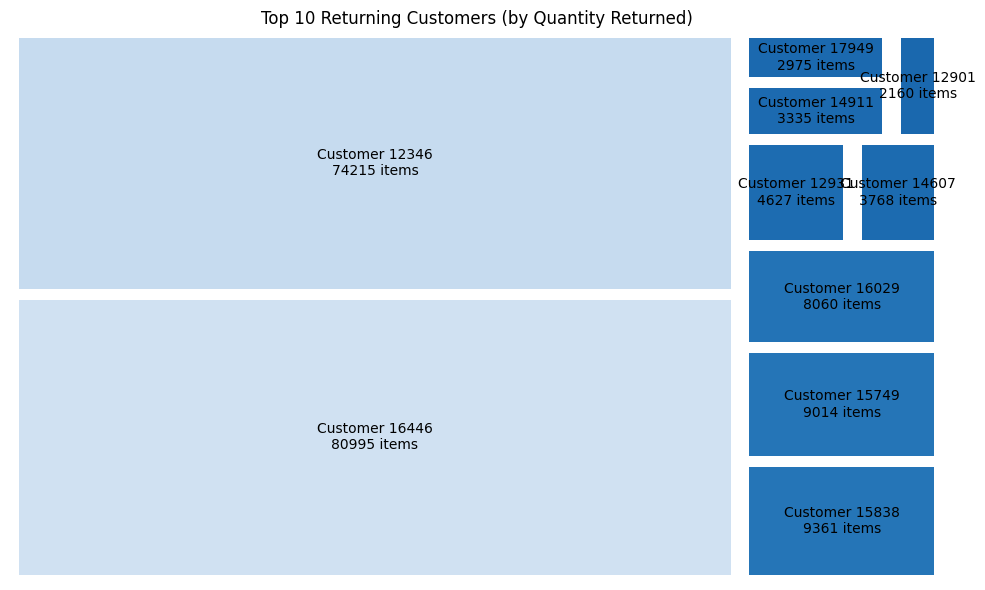

In [27]:
# Prepare data
labels = [f"Customer {int(cid)}\n{abs(qty)} items" for cid, qty in zip(trc['CustomerID'], trc['Quantity'])]
sizes = abs(trc['Quantity'])  # Treemap can't handle negative values
norm_sizes = sizes / max(sizes)
scaled_sizes = 0.2 + 0.6 * norm_sizes  # maps values to range [0.3, 1.0]
colors = plt.cm.Blues_r(scaled_sizes)  # Color gradient by size

# Plot
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, pad=True)
plt.title("Top 10 Returning Customers (by Quantity Returned)")
plt.axis('off')
plt.tight_layout()
plt.show();

In [28]:
# Total financial value of returns per product
returns_df = returns_df.copy()
returns_df['ReturnValue'] = returns_df['Quantity'] * returns_df['UnitPrice']



# Most costly products in returns
costliest_returns = (
    returns_df
    .groupby('Description')['ReturnValue']
    .sum()
    .sort_values()
    .reset_index()
)

costliest_returns.head(10)


,Description,ReturnValue
0,AMAZON FEE,-235281.59
1,"PAPER CRAFT , LITTLE BIRDIE",-168469.60
2,Manual,-146784.46
3,MEDIUM CERAMIC TOP STORAGE JAR,-77479.64
4,POSTAGE,-11871.24
5,REGENCY CAKESTAND 3 TIER,-9722.55
6,CRUK Commission,-7933.43
7,Bank Charges,-7340.64
8,WHITE HANGING HEART T-LIGHT HOLDER,-6624.30
9,FAIRY CAKE FLANNEL ASSORTED COLOUR,-6591.42


In [29]:
df.to_csv('online_retail_store_raw_data.csv')

In [30]:
onret.to_csv('online_retail_store_cleaned_data.csv')

In [31]:
rfm.to_csv("rfm_table.csv", index=False)

In [32]:
returns_df.to_csv("returns_data.csv", index=False)

In [33]:
cohort_counts.to_csv("cohort_retention_counts.csv")

In [34]:
revenue_pivot.to_csv("cohort_revenue.csv")